# An RBC model

In this notebook we show how to solve a simple RBC model in sequence space.

In [17]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## RBC model


Let's consider an RBC model wihout capital with the following equilibrium conditions

$$
\textbf{H}_t(\textbf{Y}, \hat{a}) \equiv 
\begin{pmatrix}
\hat{a}_t + \hat{n}_{t} - \hat{y}_t \\
 \hat{a}_t - (\hat{w}_t - \hat{p}_t )\\
\varphi \hat{n}_t + \gamma \hat{c}_t - (\hat{w}_t - \hat{p}_t )\\
\hat{c}_t - \hat{y}_t\\
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\qquad t = 0, 1, \dots 
\tag{1}
$$
where $\textbf{Y} = \{\hat{c}, \hat{n}, \hat{y}, \hat{w}-\hat{p}\}$ denotes the set of endogenous variables, and $\hat{a}$ is the only exogenous variable. 

#### The RBC DAG
The 4 equations of the RBC model without capital can be organized as three blocks which form a DAG in one unknown $\mathbf{U} = \mathbf{\hat{n}}$ and one targets, goods market clearing. 

1. Firm block:
    - $\hat{y}_t=\hat{a}_t + \hat{n}_{t} $
    - $\hat{w}_t - \hat{p}_t = \hat{a}_t$
2. Household block:
   - $\hat{w}_t - \hat{p}_t =\varphi \hat{n}_t + \gamma \hat{c}_t $
3. Market clearing block:
   - $0=\hat{c}_t - \hat{y}_t$

The DAG captures the following logic: given $\mathbf{U} = \mathbf{\hat{n}}$ we can solve for for $\mathbf{\hat{y}}$, and $\mathbf{\hat{w}-\hat{p}}$ in the firm block. Then given $\mathbf{U}$ and $\mathbf{\hat{w}-\hat{p}}$, we solve for $\mathbf{\hat{c}}$ in the household block. Finally, we verify that our sequences are consistent with market clearing in the market clearing block.

The image below shows a visualization of the DAG.


![title](RBCnocapitalDAG.png)

We write the reduced system as
$$
\textbf{H}_t(\textbf{U}, \hat{a}) = 0
$$

We next set up the matrices as we did in class. First define the parameters.

In [18]:
gamma = 1
beta = 0.95
phi = 1
T = 100

Next we set up the matrices in the market clearing block, which we use to construct $\partial \mathbf{H}/ \partial \mathbf{Y}$.

In [11]:
# define sparse identity, above-diagonal sparse matrix, below-diagonal sparse matrix, and zero matrix
I = sp.sparse.eye(T)
Ip1 = sp.sparse.diags([np.ones(T-1)], [1], (T, T)) # identity matrix with 1s above main diagonal
Im1 = sp.sparse.diags([np.ones(T-1)], [-1], (T, T)) # identity matrix with 1s below main diagonal
Z = sp.sparse.csr_matrix((T, T))

# market clearing block: goods market clearing
Phigmc = I
Phigmy = -I
Phigmwp = Z
print(Phigmwp.shape)

# combine matrix blocks in a single sparse matrix with the following structure:
# [Phigmc Phigmy Phigmwp]
# [Phieulc Phieuli Phieuly Phieulrk Phieulwp]
dHdY = sp.sparse.bmat([[Phigmc, Phigmy, Phigmwp]])
assert dHdY.shape == (T,3*T)

(100, 100)


Next we construct $\partial \mathbf{Y} / \partial \mathbf{U}$ and $\partial \mathbf{Y} / \partial \mathbf{Z}$ using the blocks. Start with the firm block.

In [19]:
# firm block matrices: output
Phiya = I
Phiyn = I

# firm block matrices: labor demand
Phiwpa = I

# combine firm matrices in the following format:
# [Phiyk Phiyn]
# [Phirkk Phirkn]
# [Phiwpk Phiwpn]
dYFdU = sp.sparse.bmat([[Phiyn], 
                        [Phiwpa]])
                      

# combine firm matrices in the following format:
# [Phiya]
# [Phiwpa]
# [Phirka]
dYFdZ = sp.sparse.bmat([[Phiya],
                       [Phiwpa]])

assert dYFdU.shape == (2*T, T)
assert dYFdZ.shape == (2*T, T)

Then move on to the household block.

In [20]:
# household block matrix: labor supply
Phicwp = 1/gamma * I
Phicn = -1/gamma * phi * I

# combine household matrices in the following format:
# [Phick Phicn]
# [Phiik Phiin]
dYHdU = sp.sparse.bmat([[Phicn]])

# combine household matrices in the following format:
# [Phick Phicn]
# [Phiik Phiin]
dYHdZ = sp.sparse.bmat([[Phicwp]])

assert dYHdU.shape == (T, T)
assert dYHdZ.shape == (T, T)

Now stack the household block on top of the firm block to get $\partial \mathbf{Y} / \partial \mathbf{U}$ and $\partial \mathbf{Y} / \partial \mathbf{Z}$.

In [21]:
# stack dYHdU on top of dYFdU to get dYdU
dYdU = sp.sparse.bmat([[dYHdU],
                      [dYFdU]])

# stack dYHdZ on top of dYFdZ to get dYdZ
dYdZ = sp.sparse.bmat([[dYHdZ],
                      [dYFdZ]])

assert dYdU.shape == (3*T, T)
assert dYdZ.shape == (3*T, T)

We have everything now to compute the solution.

In [22]:
# compute dHdU using the chain rule dHdU = dHdY @ dYdU (@ is the python matrix multiplication operator)
dHdU = dHdY @ dYdU 

# compute dHdZ using the chain rule dHdZ = dHdY @ dYdZ (@ is the python matrix multiplication operator)
dHdZ = dHdY @ dYdZ

assert sp.sparse.issparse(dHdZ) == True
assert sp.sparse.issparse(dHdU) == True

assert dHdU.shape == (T, T)
assert dHdZ.shape == (T, T)

# compute the Jacobian of the model
dUdZ = - sp.sparse.linalg.spsolve(dHdU, dHdZ)
dYdZ = dYdU @ dUdZ + dYdZ

dXdZ = sp.sparse.bmat([[dUdZ],
                      [dYdZ]])

assert dUdZ.shape == (T, T)
assert dYdZ.shape == (3*T, T)
assert dXdZ.shape == (4*T, T)

/Users/rileylewers/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/Users/rileylewers/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Plot IRF for an AR(1) TFP shock with persistence rho

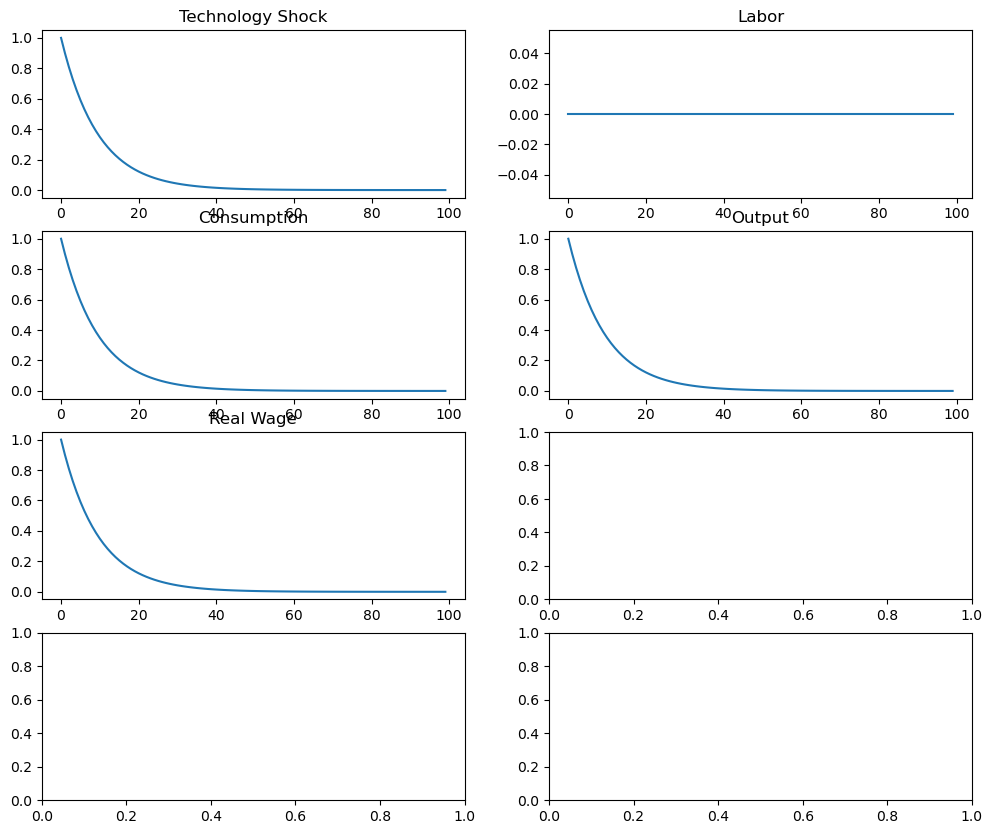

In [24]:
# plot IRFs to TFP shock with persistence rho
rho = 0.9
a = np.zeros((T, 1))
a[0] = 1
for t in range(1, T):
    a[t] = rho * a[t-1]

# compute impulse response functions
X = dXdZ @ a

# unpack X into its components n,c,y,wp,rk
n = X[0:T]
c = X[T:2*T]
y = X[2*T:3*T]
wp = X[3*T:4*T]
    
# plot impulse response functions
fig, ax = plt.subplots(4, 2, figsize=(12, 10))
ax[0, 0].plot(a, label='a')
ax[0, 0].set_title('Technology Shock')
ax[0, 1].plot(n, label='n')
ax[0, 1].set_title('Labor')
ax[1, 0].plot(c, label='c')
ax[1, 0].set_title('Consumption')
ax[1, 1].plot(y, label='y')
ax[1, 1].set_title('Output')
ax[2, 0].plot(wp, label='wp')
ax[2, 0].set_title('Real Wage')
plt.savefig('IRFs.png')

